In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [31]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [32]:
df=pd.read_csv("/content/Tether USDt Historical Data.csv")

In [33]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,11-10-2024,0.9993,0.9992,0.9994,0.9990,275.05M,0.02%
1,10-10-2024,0.9992,0.9992,0.9992,0.9987,418.75M,0.00%
2,09-10-2024,0.9991,0.9994,0.9995,0.9990,403.67M,-0.03%
3,08-10-2024,0.9994,0.9998,0.9999,0.9993,484.94M,-0.04%
4,07-10-2024,0.9998,1.0000,1.0001,0.9997,348.69M,-0.02%


In [34]:
df.drop(columns=['Open','High','Low','Vol.','Change %'],inplace=True)
df.head()

,Date,Price
0,11-10-2024,0.9993
1,10-10-2024,0.9992
2,09-10-2024,0.9991
3,08-10-2024,0.9994
4,07-10-2024,0.9998


In [35]:
df['Price'] = df['Price'].iloc[::-1].values

In [36]:
# Limit the DataFrame to the last 100 rows
df = df.tail(1000)

# Display the number of rows and columns after limiting
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")


Number of rows: 1000
Number of columns: 2


In [37]:
date = pd.date_range(start='2021-01-01', periods=min(len(df), 1000), freq='D')

In [38]:
df['Year']=date
df.drop('Date',axis=1,inplace=True)
df=df.set_index('Year')
df.head()

,Price
Year,
2021-01-01,1.0003
2021-01-02,1.0003
2021-01-03,1.0002
2021-01-04,1.0003
2021-01-05,1.0001


In [39]:
df.index = pd.to_datetime(df.index)

# Convert 'Price' column to float after removing commas
df['Price'] = df['Price'].replace(',', '', regex=True).astype(float)

# Verify the data types after conversion
print(df.dtypes)

Price    float64
dtype: object


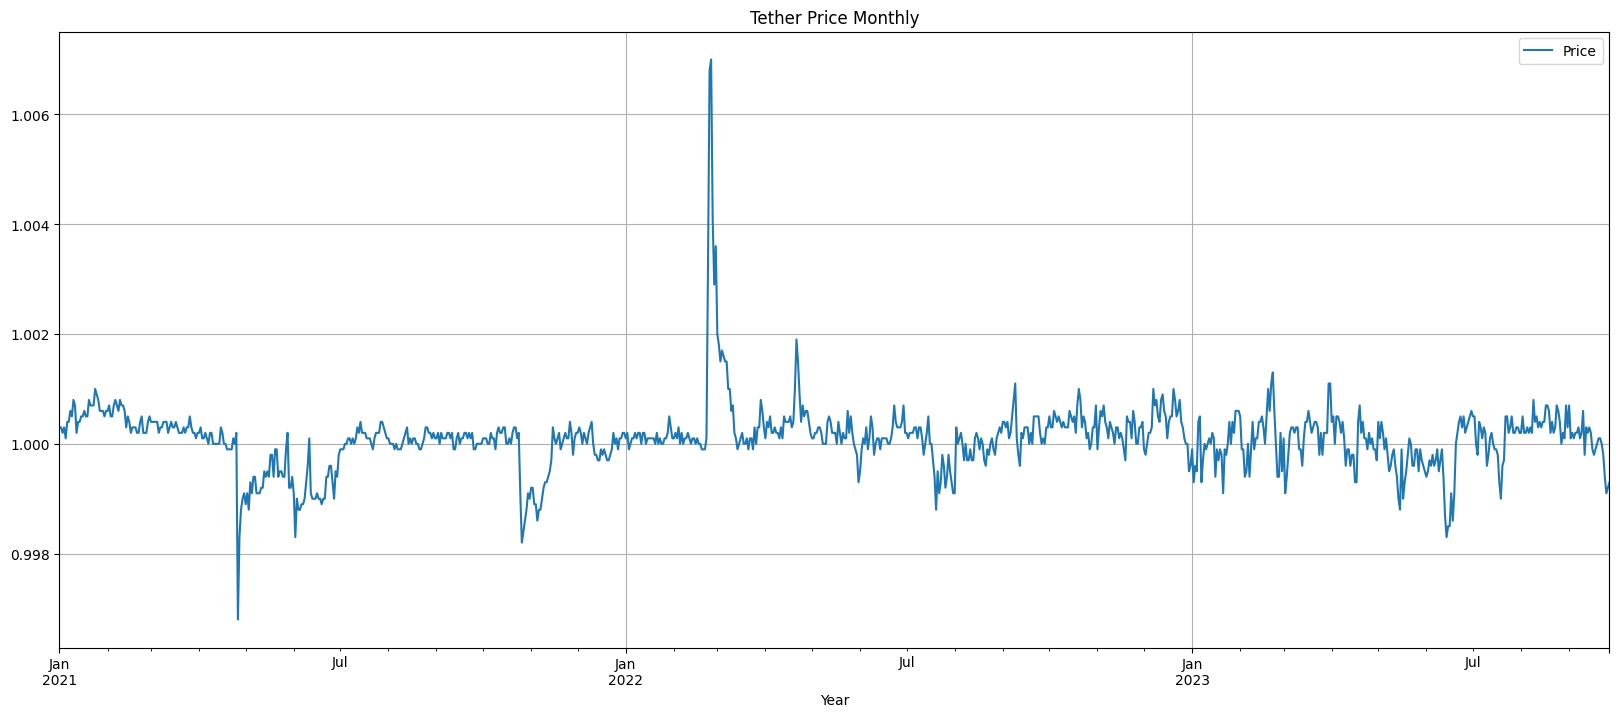

In [40]:
df.plot(figsize=(20,8))
plt.title("Tether Price Monthly")
plt.grid()

In [41]:
df.describe()

,Price
count,1000.000000
mean,1.000095
std,0.000611
min,0.996800
25%,0.999900
50%,1.000100
75%,1.000300
max,1.007000


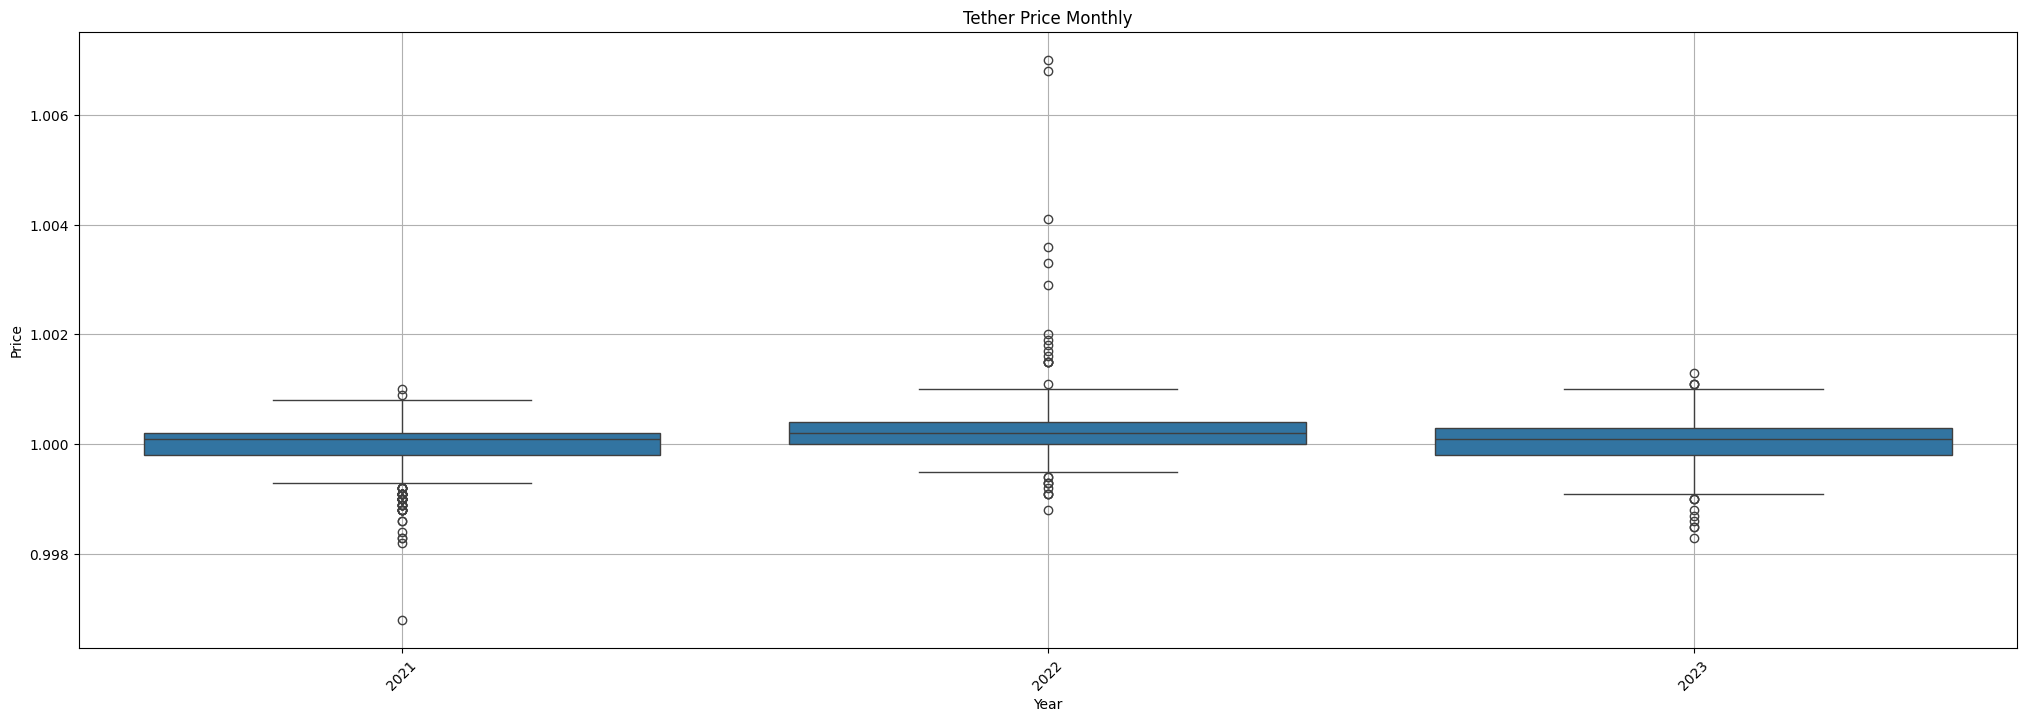

In [42]:
_ , ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.year , y=df.values[:,0] , ax=ax)
plt.title("Tether Price Monthly")
plt.xlabel(f"Year")
plt.ylabel(f"Price")
plt.xticks(rotation=45)
plt.grid()

Text(0.5, 1.0, 'Tether Price Monthly')

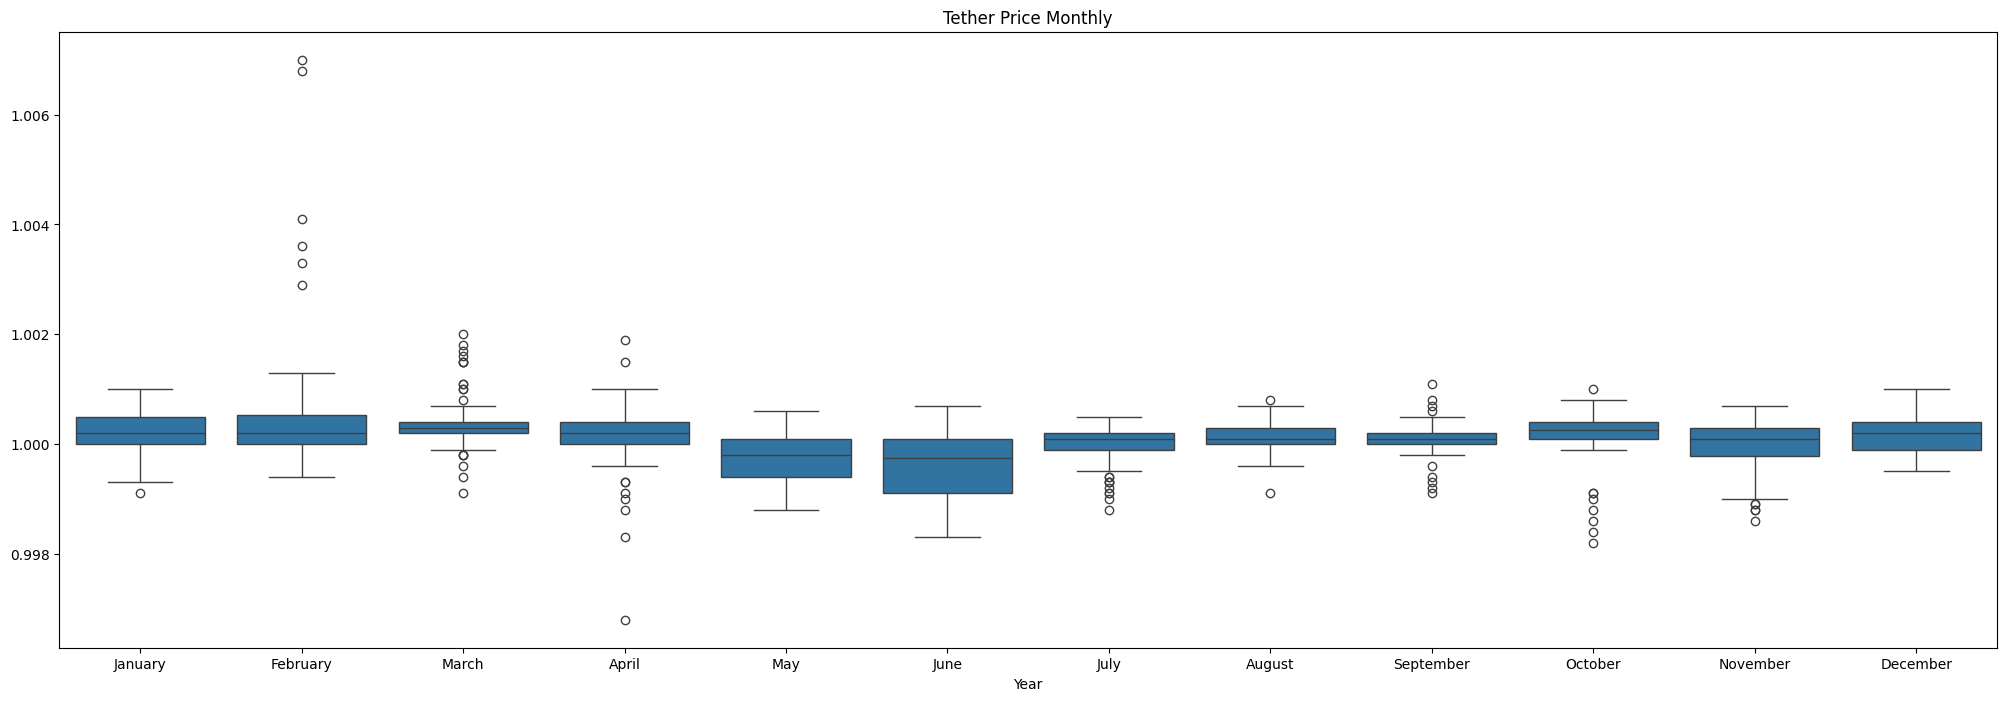

In [43]:
_ , ax = plt.subplots(figsize=(25,8))
sns.boxplot(x = df.index.month_name() , y = df.values[:,0], ax=ax)
plt.title("Tether Price Monthly")

In [44]:
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price' : 'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price' : 'Std'}), left_index=True, right_index=True)
df_1['Cov_pct'] = ((df_1['Std']/df_1['Mean'])*100 ).round(2)

In [45]:
df_1.head()

,Mean,Std,Cov_pct
Year,,,
2021,0.999950,0.000534,0.05
2022,1.000293,0.000717,0.07
2023,1.000022,0.000468,0.05


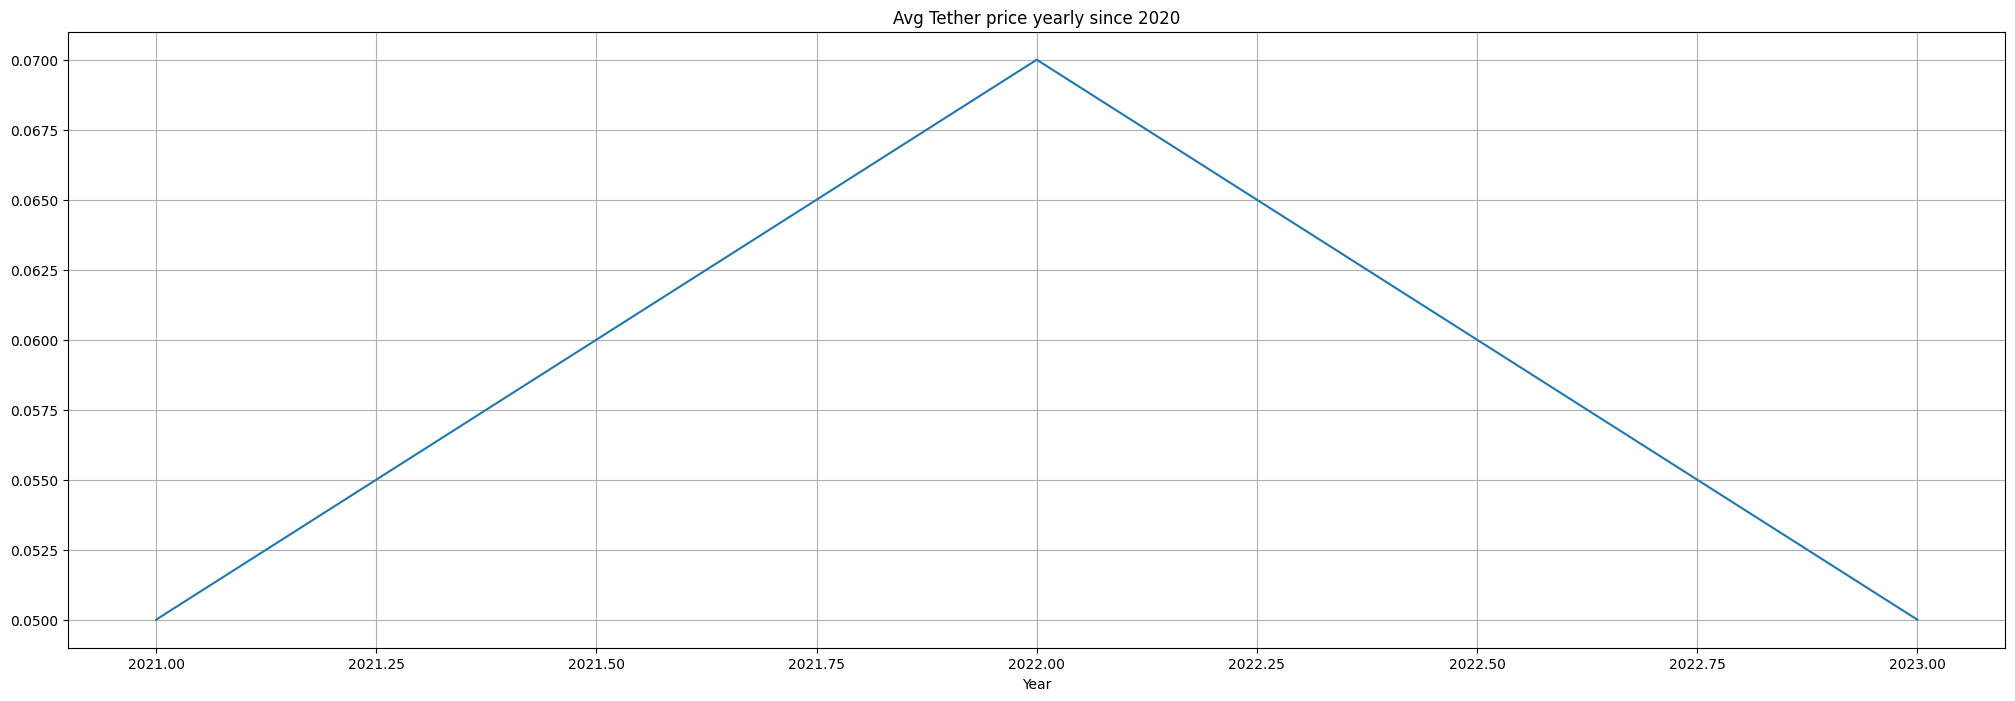

In [46]:
fig , ax = plt.subplots(figsize=(25,8))
df_1['Cov_pct'].plot()
plt.title("Avg Tether price yearly since 2020")
plt.grid()

In [47]:
train = df[df.index.year <= 2022]
test = df[df.index.year > 2022]

In [48]:
print(train.shape)
print(test.shape)

(730, 1)
(270, 1)


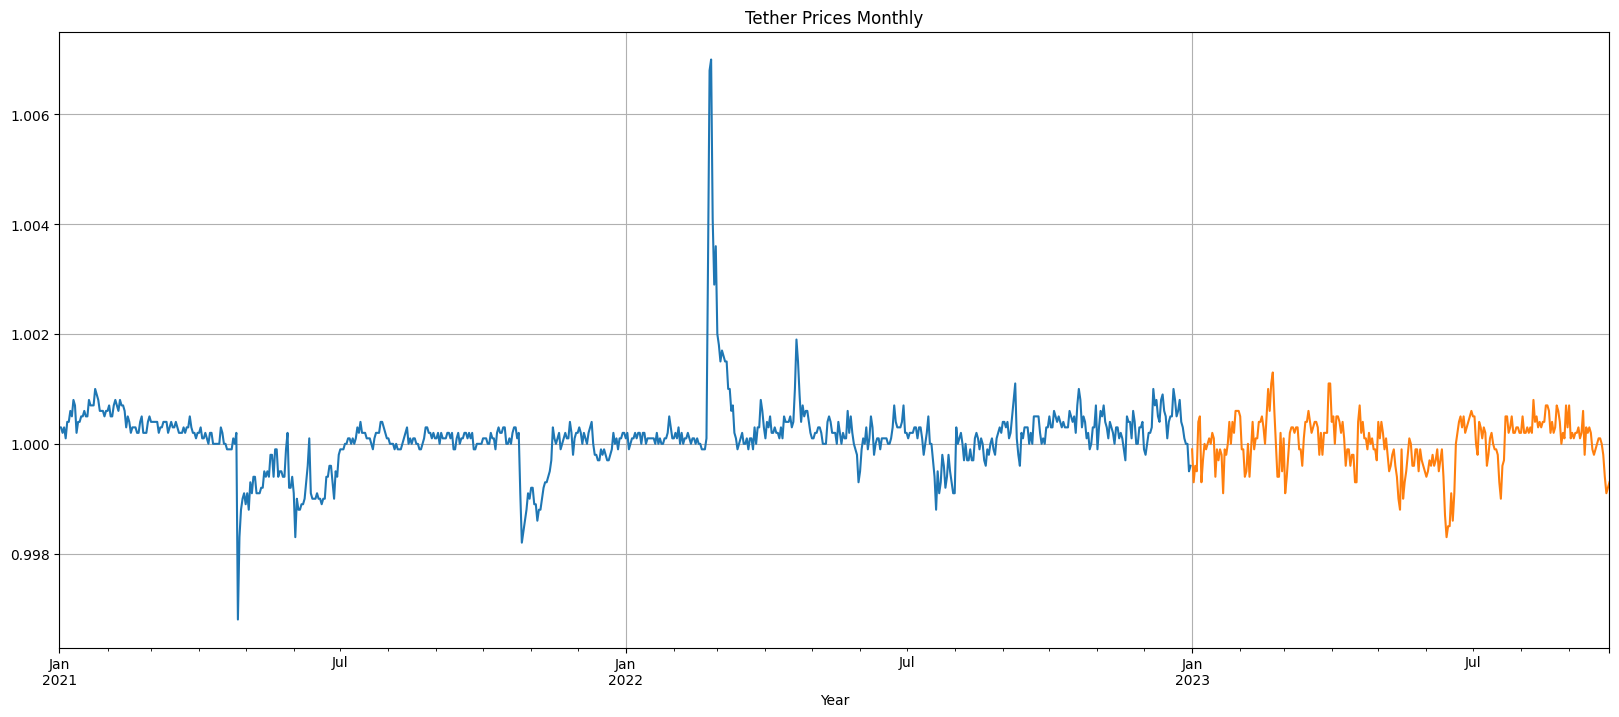

In [49]:
train['Price'].plot(figsize=(20,8))
test['Price'].plot(figsize=(20,8))
plt.title("Tether Prices Monthly")
plt.grid()

In [50]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+1 for i in range(len(test))]
len(train_time), len(test_time)

(730, 270)

In [51]:
Naive_train = train.copy()
Naive_test = test.copy()

In [52]:
LR_train = train.copy()
LR_test = test.copy()

In [53]:
Naive_train['time'] = train_time
Naive_test['time'] = test_time

In [54]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [55]:
Naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

,naive
Year,
2023-01-01,0.9996
2023-01-02,0.9996
2023-01-03,0.9996
2023-01-04,0.9996
2023-01-05,0.9996


In [56]:
lr = LinearRegression()
lr.fit(LR_train[['time']], LR_train['Price'].values)

LinearRegression()

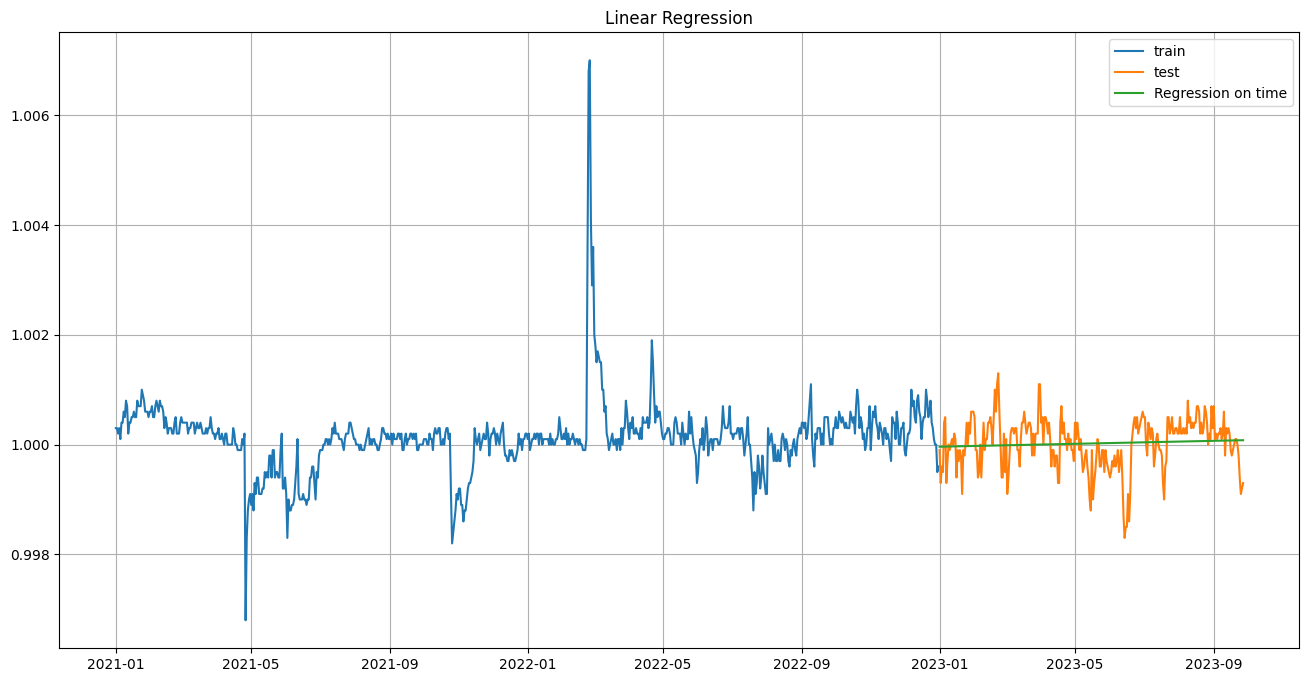

In [57]:
test_predictions_model = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_predictions_model
plt.figure(figsize=(16,8))
plt.plot(train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(LR_test['forecast'], label='Regression on time')
plt.title('Linear Regression')
plt.legend(loc='best')
plt.grid()
plt.show()

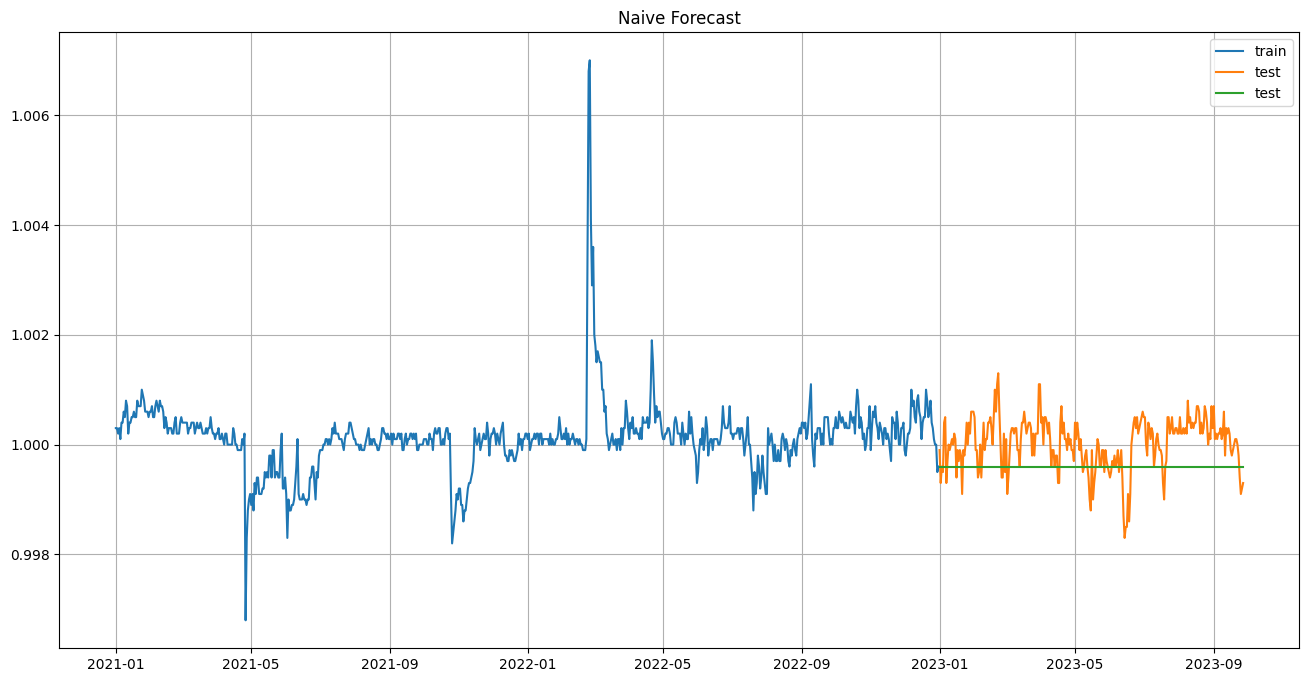

In [58]:
plt.figure(figsize=(16,8))
plt.plot(Naive_train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(Naive_test['naive'],label='test')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.grid()
plt.show()

In [59]:
def mape(actual,pred):
  return round((np.mean(abs(actual - pred)/actual))*100 , 2)

In [60]:
mape_model_test = mape(test['Price'].values,test_predictions_model)
print("MAPE is %3.3f"%(mape_model_test),"%")

MAPE is 0.040 %


In [61]:
results = pd.DataFrame({'Test MAPE (%)': [mape_model_test]}, index=["Regression"])

In [62]:
results

,Test MAPE (%)
Regression,0.04


In [63]:
mape_model_test_2 = mape(test['Price'].values,Naive_test['naive'].values)
print("For Naive Forecast on Test data the MAPE is %3.3f"%(mape_model_test_2),"%")

For Naive Forecast on Test data the MAPE is 0.050 %


In [64]:
results_2 = pd.DataFrame({'Test MAPE (%)': [mape_model_test_2]}, index=["Naive Model"])
result_final = pd.concat( [results,results_2])
result_final

,Test MAPE (%)
Regression,0.04
Naive Model,0.05


In [65]:
final_model = ExponentialSmoothing(df['Price'],trend='additive',seasonal='additive',seasonal_periods=12).fit(smoothing_level=0.4,smoothing_trend=0.3,smoothing_seasonal=0.6)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [66]:
# Ensure the forecasting period doesn't extend too far into the future
forecast_horizon = min(len(test), 30)  # Change 100 to a reasonable number if needed

# Perform the forecast
forecast = final_model.forecast(forecast_horizon)

# Compute the MAPE for the test period, ensuring it matches the forecast horizon
mape_final_model = mape(test['Price'].values[:forecast_horizon], forecast)
print("For Final Model on Test data the MAPE is %3.3f" % mape_final_model, "%")


For Final Model on Test data the MAPE is 0.130 %


In [67]:
# Limit the forecast horizon to prevent the out-of-bounds error
forecast_horizon = min(len(df), 20)  # Adjust 100 to a smaller number if needed

# Perform the forecast
prediction = final_model.forecast(forecast_horizon)


In [68]:
pred_df = pd.DataFrame({'lower_CI':prediction - 1.96*np.std(final_model.resid,ddof=1) , 'prediction':prediction , 'upper_CI':prediction + 1.96*np.std(final_model.resid,ddof=1)})

Text(0.5, 1.0, 'Final Model')

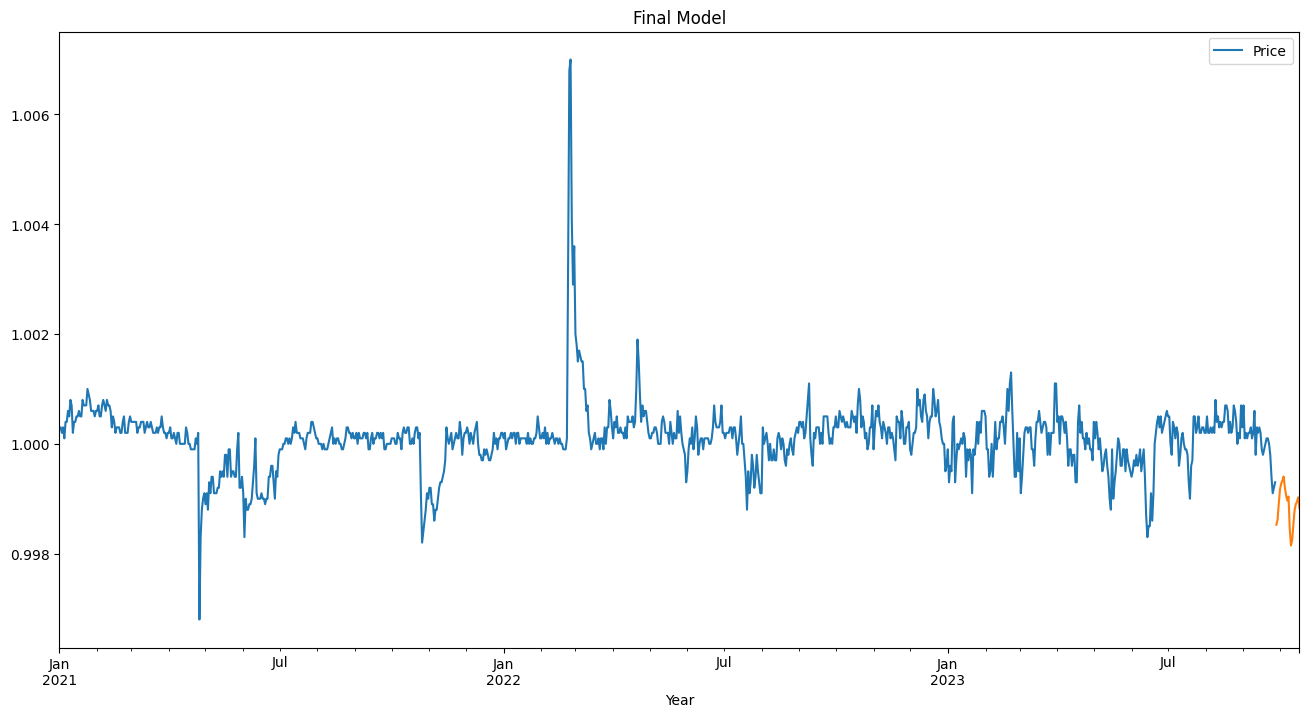

In [69]:
axis = df.plot(label = 'Actual',figsize=(16,8))
pred_df['prediction'].plot(ax=axis,label='Predicted')
plt.title('Final Model')

In [70]:
import pickle
from sklearn.linear_model import LinearRegression

# Save the model
with open('tether_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)
print("Model saved successfully as 'tether_model.pkl'.")

# Load the model
with open('tether_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")


Model saved successfully as 'tether_model.pkl'.
Model loaded successfully.
